In [1]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3

import math

from shapely import geometry

import tqdm

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

import seaborn as sns

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

import cloudpickle


sys.path.append('../analysis/physiology/')
import tpc

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:36991 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Use Generalized TPC to extrapolate performance geographically

In [`./physiology/TPC_params_latitudinal_generalization.ipynb`](./physiology/TPC_params_latitudinal_generalization.ipynb) we develop models to characterize the relationship between latitude and $T_\mathrm{opt}$,  $T_\mathrm{min}$, and $T_\mathrm{max}$ in an effort to parameterize a general thermal performance curve function developed by [Deutsch *et al.* 2008](https://www.pnas.org/content/105/18/6668). 

In the above notebook we generate a `GeneralizedTPC` class and instantiate it with the models of Topt, Tmin, and Tmax derived from the data. This instantiation is saved into `./physiology/gtpc_modeled.pkl`, which we load here: 

In [3]:
with open("./physiology/gtpc_modeled.pkl", 'rb') as f:
    gtpc = cloudpickle.load(f)

## An Example: 

At $45^\circ$ latitude:

In [4]:
latitude = 25
topt, tmin, tmax = gtpc.getTPCParameters(latitude)
tpc = gtpc.getLatitudinalTPC(latitude)

Text(0.5, 1.0, 'Latitude: $25^\\circ$')

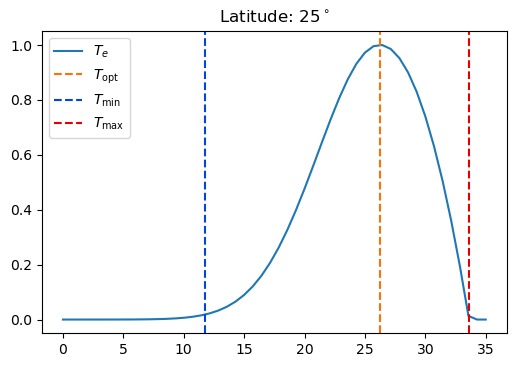

In [5]:
plt.figure(dpi=100)
T = np.linspace(0, 35)
T_e = tpc(T)
plt.plot(T, T_e, label=R'$T_e$')
plt.axvline(topt, color='xkcd:orange', linestyle='--', label=r'$T_\mathrm{opt}$')
plt.axvline(tmin, color='xkcd:blue', linestyle='--', label=r'$T_\mathrm{min}$')
plt.axvline(tmax, color='xkcd:red', linestyle='--', label=r'$T_\mathrm{max}$')
plt.legend()
plt.title(f"Latitude: ${latitude}^\circ$")

## Applied to actual MHWs 

Load MHWs + SST: 

In [6]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [7]:
## Set up Plotting
CENTRAL_LONGITUDE = ((mhws.lon.max() + mhws.lon.min()) / 2).values
CENTRAL_LATITUDE = ((mhws.lat.max() + mhws.lat.min()) / 2).values
PLOT_MAP_PROJECTION = ccrs.Stereographic(central_longitude=CENTRAL_LONGITUDE)
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

### Compute Performance Latitudinally

In [9]:
performance = xr.full_like(oisst_pnw, fill_value=0.).rename_vars({'sst' : "performance"})
performance['performance_clim'] = xr.zeros_like(performance.performance)
performance['topt'] = xr.zeros_like(performance.performance)
performance['tmin'] = xr.zeros_like(performance.performance)
performance['tmax'] = xr.zeros_like(performance.performance)
performance.attrs = {}



In [ ]:
for lat in tqdm.tqdm(performance.lat.values):
    latitude = lat.copy()
    _tpc = gtpc.getLatitudinalTPC(lat)
    _topt, _tmin, _tmax = gtpc.getTPCParameters(lat)
    values = xr.apply_ufunc(
        _tpc,
        oisst_pnw.sel(lat = lat).chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).compute().sst.T
    
    values_clim = xr.apply_ufunc(
        _tpc,
        mhws.clim_seas.sel(lat = lat).chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).compute().T
    
    performance['performance'].loc[
        dict(lat = lat)
    ] = values
    
    performance['performance_clim'].loc[
        dict(lat = lat)
    ] = values_clim
    
    
    performance['topt'].loc[
        dict(lat = lat)
    ] = _topt
    
    performance['tmin'].loc[
        dict(lat = lat)
    ] = _tmin
    
    performance['tmax'].loc[
        dict(lat = lat)
    ] = _tmax
    
    

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [15]:
performance.to_netcdf("pnw_performance.nc")

In [8]:
performance = xr.open_dataset("pnw_performance.nc")

## Check via Plotting

In [13]:
timeRange = slice('2000', '2016')
thisPerformance = performance.sel(time=timeRange)

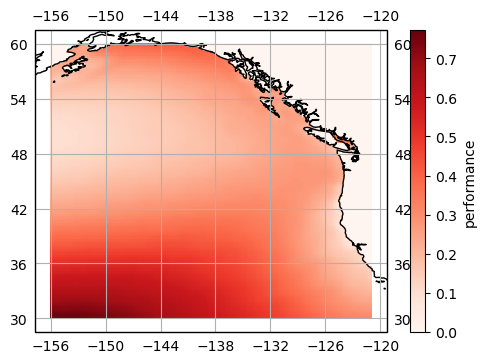

In [14]:
fig = plt.figure(dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
thisPerformance.mean(dim='time').performance.plot(ax=ax, cmap='Reds', transform=ccrs.PlateCarree())
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.gridlines(draw_labels=True)

In [58]:
small_region = {
    'lon' : slice(-138, -132),
    'lat': slice(36, 42)
}

In [16]:
performance_detriment = 1 - thisPerformance.performance
performance_detriment_clim = 1 - thisPerformance.performance_clim
detriment_ratio = performance_detriment / performance_detriment_clim

(735234.0, 735599.0)

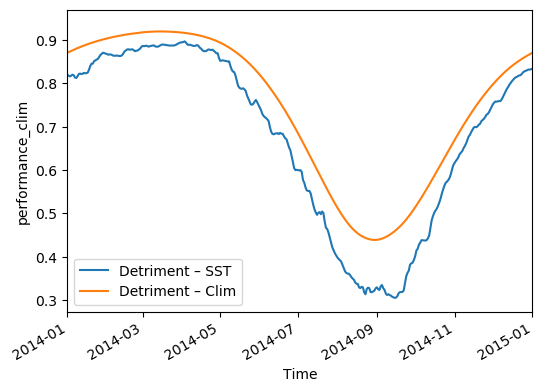

In [17]:
plt.figure(dpi=100)
performance_detriment.mean(['lat', 'lon']).plot(label='Detriment – SST')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Detriment – Clim')
plt.legend()
plt.xlim(['2014', '2015'])

(735234.0, 735599.0)

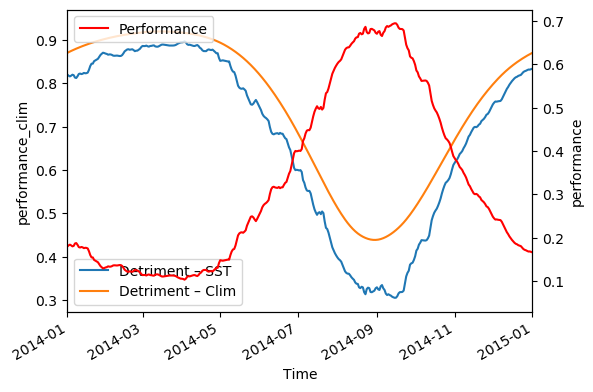

In [19]:
plt.figure(dpi=100)
performance_detriment.mean(['lat', 'lon']).plot(label='Detriment – SST')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Detriment – Clim')
plt.legend()
ax2 = plt.twinx()
(thisPerformance.performance).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red', label='Performance')
plt.legend()
plt.xlim(['2014', '2015'])

(735234.0, 735599.0)

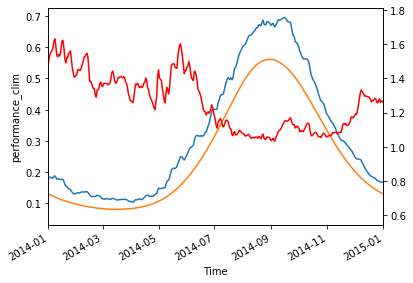

In [64]:
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
ax2 = plt.twinx()
(thisPerformance.performance / thisPerformance.performance_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red')

plt.xlim(['2014', '2015'])

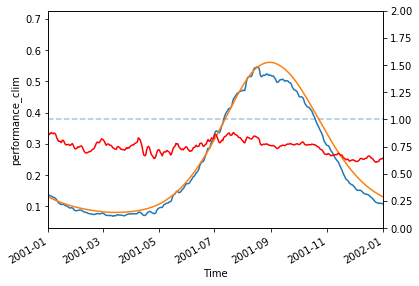

In [20]:
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
ax2 = plt.twinx()
(thisPerformance.performance / thisPerformance.performance_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red')
ax2.set_ylim(0, 2)
plt.xlim(['2001', '2002'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)

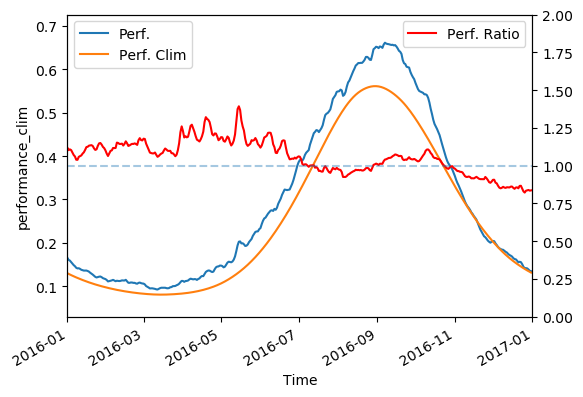

In [21]:
plt.figure(dpi=100)
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
plt.legend()

ax2 = plt.twinx()
(thisPerformance.performance / thisPerformance.performance_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red', label='Perf. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2016', '2017'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


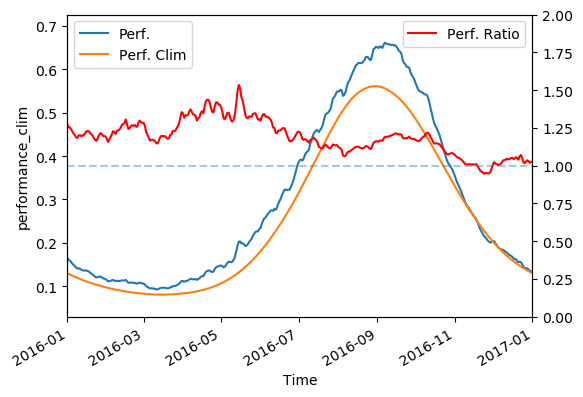

In [96]:
plt.figure(dpi=100)
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
plt.legend()

ax2 = plt.twinx()
(thisPerformance.performance.mean(dim=['lat', 'lon']) / thisPerformance.performance_clim.mean(dim=['lat', 'lon'])).plot(ax=ax2, color='red', label='Perf. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2016', '2017'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


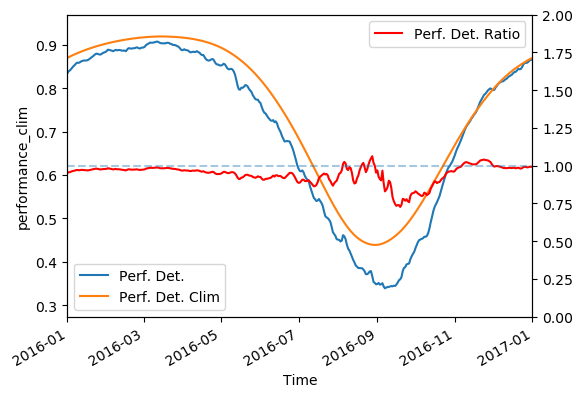

In [67]:
plt.figure(dpi=100)
performance_detriment.mean(dim=['lat', 'lon']).plot(label='Perf. Det.')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Det. Clim')
plt.legend()

ax2 = plt.twinx()
(performance_detriment / performance_detriment_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red', label='Perf. Det. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2016', '2017'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


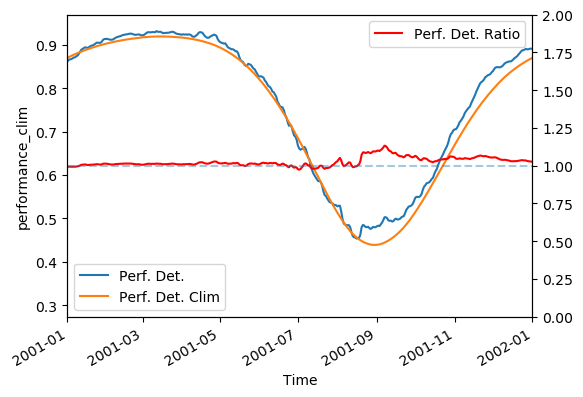

In [91]:
plt.figure(dpi=100)
performance_detriment.mean(dim=['lat', 'lon']).plot(label='Perf. Det.')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Det. Clim')
plt.legend()

ax2 = plt.twinx()
(performance_detriment.mean(dim=['lat', 'lon']) / performance_detriment_clim.mean(dim=['lat', 'lon'])).plot(ax=ax2, color='red', label='Perf. Det. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2001', '2002'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


Discovered an issue here where computing the detriment shows decently different values if it's computed mean first  or mean second

## What's the relationship between perofrmance detriment ratio and MHWs?

In [9]:
DURATION_THRESHOLD = 20
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= DURATION_THRESHOLD)
non_mhw_filter = ~mhw_only_filter

In [10]:
performance_merged = xr.merge([performance, mhws], join='inner')

In [11]:
performance_mhw = performance_merged.where(mhw_only_filter & (performance_merged.time.dt.year > 2000), drop=True)

In [14]:
performance_mhw = performance_mhw.sel(**small_region)

In [15]:
pf_df = performance_mhw.to_dataframe().reset_index()

In [16]:
pf_df = pf_df.dropna(axis=0)

In [29]:
pf_df.columns

Index(['lat', 'lon', 'time', 'performance', 'performance_clim', 'topt', 'tmin',
       'tmax', 'clim_seas', 'clim_thresh', 'duration', 'index_end',
       'index_peak', 'index_start', 'intensity_cumulative', 'intensity_max',
       'intensity_mean', 'intensity_var', 'mhw', 'rate_decline', 'rate_onset'],
      dtype='object')

In [ ]:
# pf_df_recent = pf_df[pf_df.time > '2000']

In [17]:
mhw_groups = pf_df.groupby(['lat', 'lon', 'mhw'])

In [18]:
cell_evented_mhws_perf_det = mhw_groups.apply(lambda x: (1 - x.performance).sum())
cell_evented_mhws_perf_det_scaled = mhw_groups.apply(lambda x: (1 - x.performance).mean())


In [19]:
cell_evented_mhws_perf_diff = mhw_groups.apply(lambda x: (x.performance - x.performance_clim).sum())

In [20]:
cell_evented_mhws_perf_ratio = mhw_groups.apply(lambda x: (x.performance / x.performance_clim).mean())

In [21]:
cell_evented_mhws_intense = mhw_groups.apply(lambda x: x.intensity_cumulative.min())
cell_evented_mhws_duration = mhw_groups.apply(lambda x: x.duration.min())
cell_evented_mhws_start = mhw_groups.apply(lambda x: x.time.dt.dayofyear.min())

In [22]:
cell_evented_prf_det_ratio_mean = mhw_groups.apply(lambda x: ((1-x.performance)/(1-x.performance_clim)).mean())

In [23]:
evented = pd.concat([
    cell_evented_mhws_intense.rename('intensity'),
    cell_evented_mhws_duration.rename("duration"),
    cell_evented_mhws_start.rename('startdoy'),
    cell_evented_mhws_perf_diff.rename('perf_diff'),
    cell_evented_mhws_perf_det.rename('perf_det'),
    cell_evented_mhws_perf_det_scaled.rename('perf_det_mean'), 
    cell_evented_mhws_perf_ratio.rename('perf_ratio_mean'), 
    cell_evented_prf_det_ratio_mean.rename('perf_det_ratio_mean')
], axis=1)


In [24]:
evented = evented.reset_index()

In [25]:
evented['latbin'] = pd.cut(evented.lat, bins=6)

In [26]:
evented_mhw = evented[evented.mhw > 0]

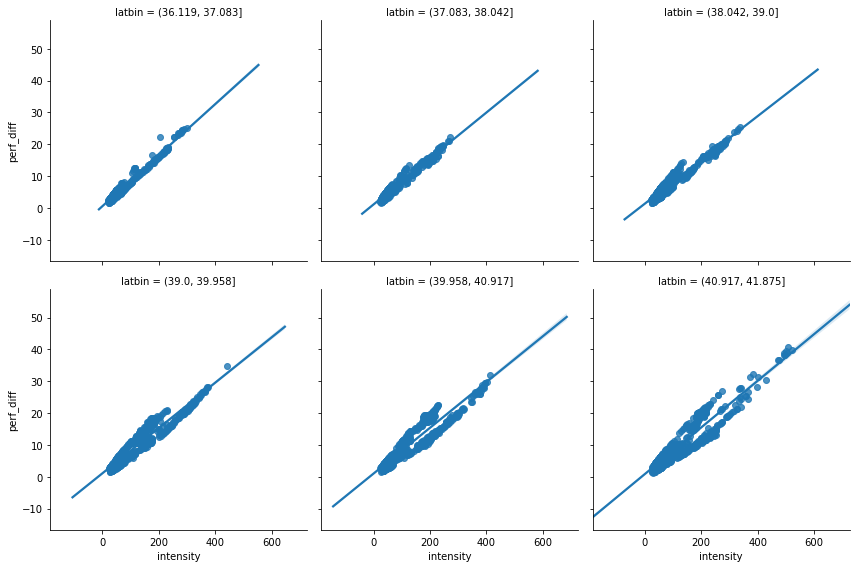

In [44]:
sns.lmplot(x = 'intensity', y = 'perf_diff', height=4, col='latbin', col_wrap=3, data=evented_mhw)

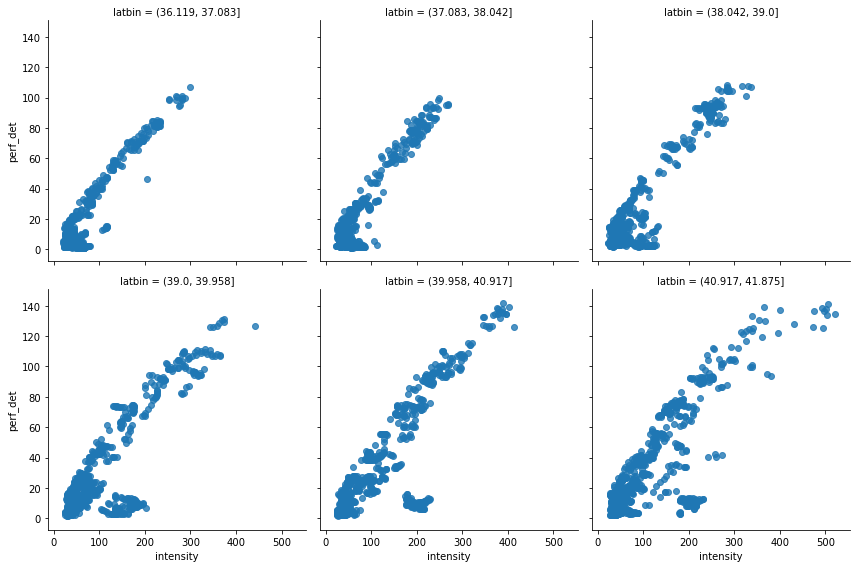

In [45]:
sns.lmplot(x = 'intensity', y = 'perf_det', col='latbin', col_wrap=3, height=4,data=evented_mhw, fit_reg=False, )

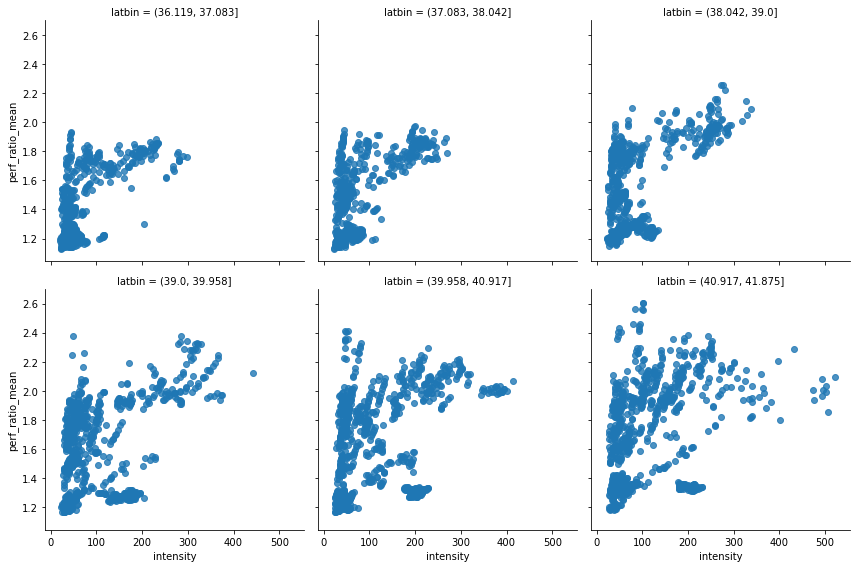

In [46]:
sns.lmplot(x = 'intensity', y = 'perf_ratio_mean', col='latbin', col_wrap=3, height=4,data=evented_mhw, fit_reg=False, )

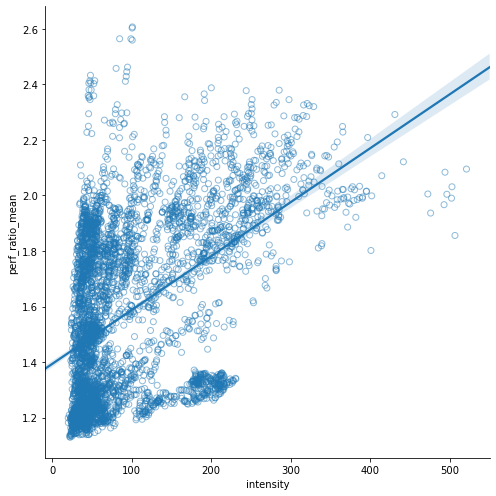

In [47]:
sns.lmplot(
    x = 'intensity',
    y = 'perf_ratio_mean', 
    height=7,data=evented_mhw, 
    fit_reg=True,
    scatter_kws=dict(facecolors='none', alpha=0.5)
)


In [ ]:
# cmap = sns.cubehelix_palette(dark=0, light=365)
sns.lmplot(x = 'intensity', y = 'perf_det_mean', col='latbin', col_wrap=2, height=7,data=evented_mhw, fit_reg=False, hue='startdoy')

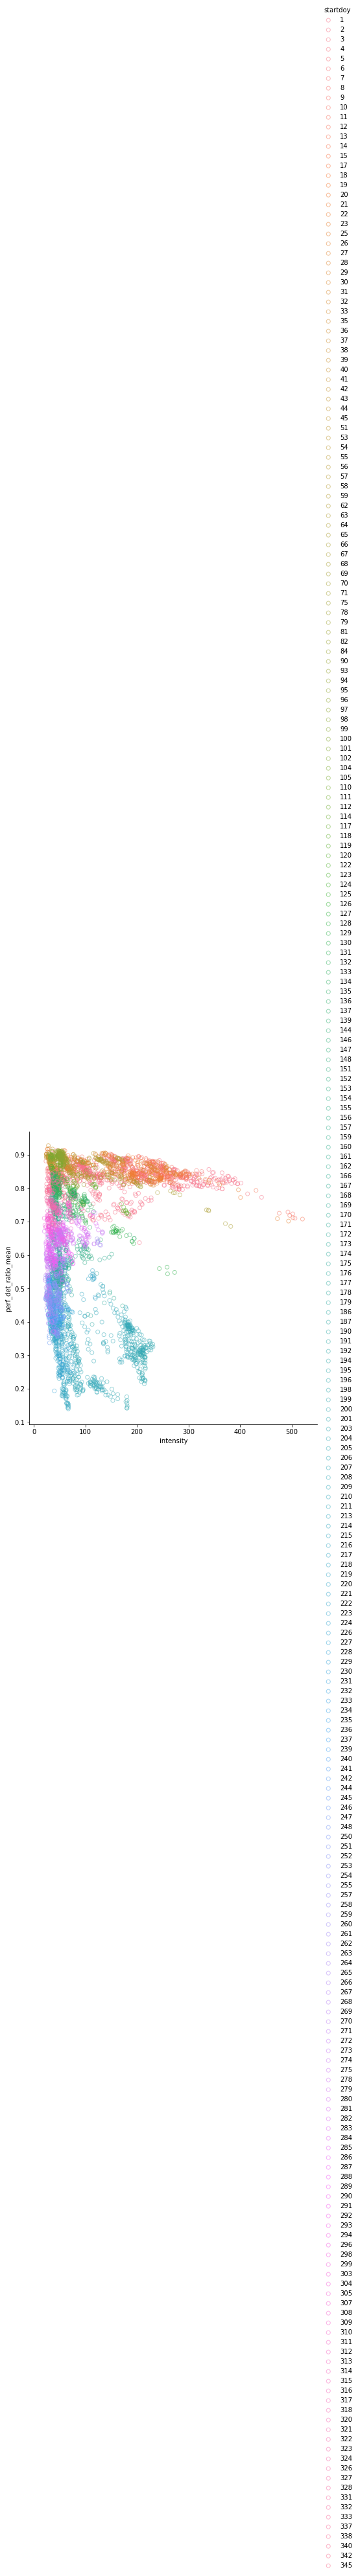

In [35]:
sns.lmplot(
    x = 'intensity', 
    y = 'perf_det_ratio_mean',
    hue = 'startdoy',
    height=7,data=evented_mhw, fit_reg=False, scatter_kws=dict(facecolors='none', alpha=0.5)
)

---

# How often does SST exceed modeled $T_\mathrm{opt}$ ?

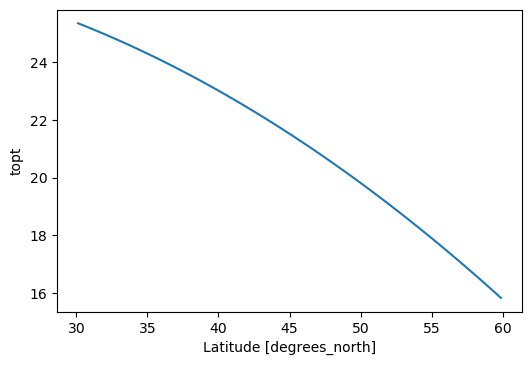

In [48]:
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$')


In [19]:
databounds = {
    'lat': slice(performance.lat.min(), performance.lat.max()),
    'lon': slice(performance.lon.min(), performance.lon.max()),
}

In [66]:
these_sst = oisst.sel(**databounds)

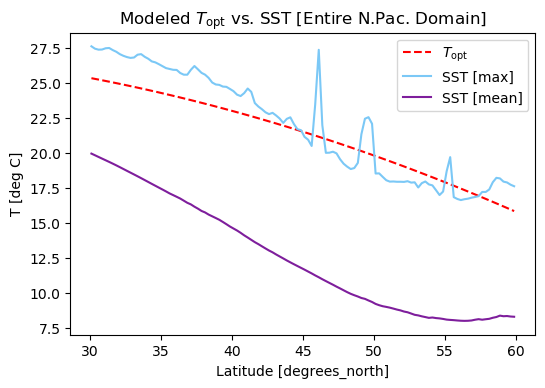

In [67]:
plt.figure(dpi=100)
ax = plt.axes()
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$', ax=ax, color='red', linestyle='--')
these_sst.sst.max(dim=['lon', 'time']).plot(ax=ax, color='xkcd:lightblue', label='SST [max]')
these_sst.sst.mean(dim=['lon', 'time']).plot(ax=ax, color='xkcd:purple', label='SST [mean]')
ax.set_ylabel("T [deg C]")
plt.title("Modeled $T_\mathrm{opt}$ vs. SST [Entire N.Pac. Domain]")

plt.legend()

**For small region above..**

In [59]:
these_sst = oisst.sel(**small_region)

In [68]:
print(small_region)

{'lon': slice(-138, -132, None), 'lat': slice(36, 42, None)}


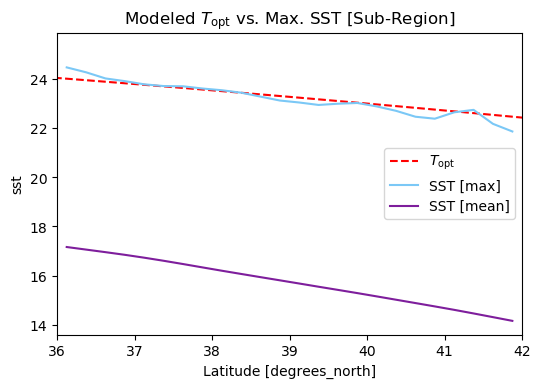

In [65]:
plt.figure(dpi=100)
ax = plt.axes()
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$', ax=ax, color='red', linestyle='--')
ax.set_ylabel("T [deg C]")
these_sst.sst.max(dim=['lon', 'time']).plot(ax=ax, color='xkcd:lightblue', label='SST [max]')
these_sst.sst.mean(dim=['lon', 'time']).plot(ax=ax, color='xkcd:purple', label='SST [mean]')
plt.title("Modeled $T_\mathrm{opt}$ vs. Max. SST [Sub-Region]")
ax.set_xlim([small_region['lat'].start, small_region['lat'].stop])
plt.legend()